In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import musicalrobot

In [2]:
from musicalrobot import edge_detection as ed
from musicalrobot import pixel_analysis as pa
from musicalrobot import post_data

In [3]:
from skimage import io
from skimage import feature
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops
from skimage.exposure import equalize_adapthist
from skimage.morphology import remove_small_objects  
from scipy.signal import find_peaks
from scipy.interpolate import BSpline
from irtemp import centikelvin_to_celsius

In [4]:
frames = ed.input_file('../musicalrobot/data/10_17_19_PPA_Shallow_plate.tiff')

In [5]:
len(frames)

887

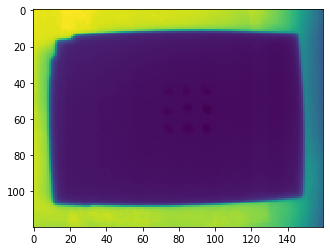

In [6]:
plt.imshow(frames[0])

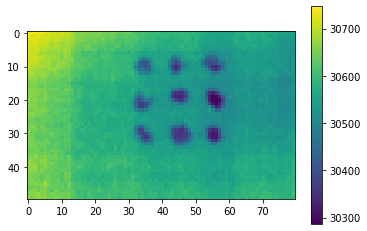

In [7]:
crop_frame = []
for frame in frames:
    crop_frame.append(frame[35:85,40:120])
plt.imshow(crop_frame[0])
plt.colorbar()

In [8]:
flip_frames = ed.flip_frame(crop_frame)

In [10]:
labeled_samples = ed.edge_detection(flip_frames)

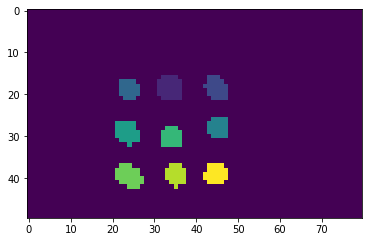

In [11]:
plt.imshow(labeled_samples)

In [12]:
regprops = ed.regprop(labeled_samples, flip_frames, 9, 3, 3)

In [13]:
regprops[0]

,Row,Column,Plate,Plate_coord,Area,Perim,Mean Intensity
0,18.0,23.0,30370.0,33.0,22.0,14.242641,30317.0
1,29.0,23.0,30368.0,33.0,28.0,17.656854,30287.0
2,39.0,23.0,30465.0,33.0,31.0,18.485281,30350.0
3,18.0,33.0,30404.0,43.0,33.0,18.242641,30370.0
4,30.0,34.0,30532.0,44.0,23.0,14.828427,30330.0
5,39.0,35.0,30430.0,45.0,23.0,15.071068,30346.0
6,18.0,44.0,30581.0,54.0,27.0,17.071068,30362.0
7,28.0,45.0,30575.0,55.0,23.0,14.828427,30378.0
8,39.0,44.0,30597.0,54.0,25.0,15.656854,30402.0


In [14]:
temp, plate_temp = ed.sample_temp(regprops, flip_frames)

Text(0.5, 1.0, 'PPA')

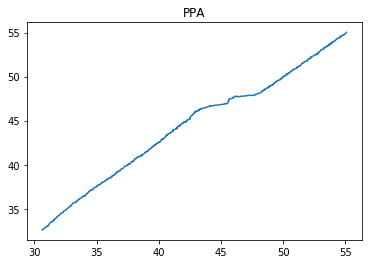

In [25]:
plt.plot(temp[7],plate_temp[7])
plt.title('PPA')

In [16]:
inf_temp, s_peaks, p_peaks = ed.inflection_point(temp, plate_temp)

ValueError: zero-size array to reduction operation maximum which has no identity

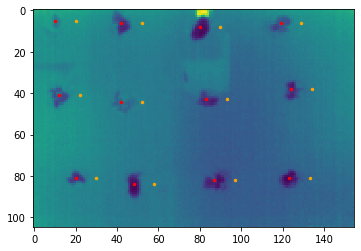

In [10]:
plt.imshow(flip_frames[0])
plt.scatter(regprops[0]['Plate_coord'],regprops[0]['Row'],c='orange',s=6)
plt.scatter(regprops[0]['Column'],regprops[0]['Row'],s=6,c='red')
# plt.title('Sample centroid and plate locations at which the temperature is monitored')

In [11]:
regprops[0]

,Row,Column,Plate,Plate_coord,Area,Perim,Mean Intensity
0,5.0,10.0,30136.0,20.0,24.0,16.000000,29978.0
1,41.0,12.0,30083.0,22.0,74.0,30.142136,29966.0
2,81.0,20.0,30036.0,30.0,43.0,23.313708,29699.0
3,6.0,42.0,30052.0,52.0,64.0,28.727922,29692.0
4,44.0,42.0,30013.0,52.0,78.0,37.556349,29904.0
5,84.0,48.0,29980.0,58.0,60.0,27.899495,29570.0
6,8.0,80.0,29982.0,90.0,91.0,40.349242,29568.0
7,43.0,83.0,29864.0,93.0,60.0,29.071068,29669.0
8,82.0,87.0,29835.0,97.0,66.0,29.899495,29728.0
9,6.0,119.0,30081.0,129.0,62.0,27.899495,29820.0


In [12]:
np.mean(inf_temp)

44.26083333333333

In [13]:
inf_temp

[46.97,
 30.23,
 47.33,
 40.19,
 43.48,
 47.51,
 44.59,
 46.2,
 44.94,
 46.27,
 44.5,
 48.92]

In [14]:
m_df = pd.DataFrame({'Row':regprops[0].Row,'Column':regprops[0].Column,'Inflection point':inf_temp})

In [15]:
# To export the final result(inflection points) as a csv
post_data.export_csv(m_df)

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\pozzo_lab_admin\Miniconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\pozzo_lab_admin\Miniconda3\lib\site-packages\musicalrobot\post_data.py", line 27, in exportCSV
    df.to_csv (export_file_path, index = None, header=True)
NameError: name 'df' is not defined


In [13]:
x = np.linspace(1,len(s_temp[0]),len(s_temp[0]))

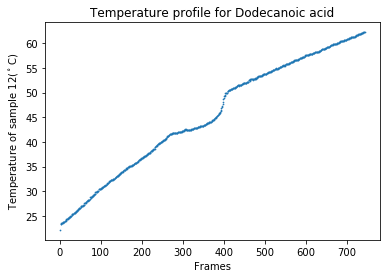

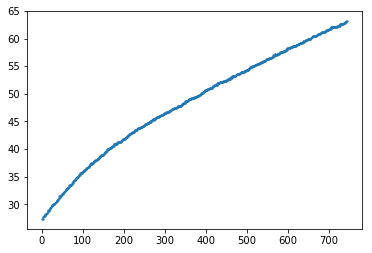

In [22]:
plt.scatter(x,s_temp[11],s=0.5)
plt.xlabel('Frames')
plt.ylabel('Temperature of sample 12($^\circ$C)')
plt.title('Temperature profile for Dodecanoic acid')
plt.show()
plt.scatter(x,p_temp[3],s=1.5)

In [12]:
def inflection_point(s_temp,p_temp):
    s_infl = []
    p_infl = []
    s_peaks = []
    p_peaks = []
    inf_peak = [] ; inf_temp = []
    for temp in s_temp:
        frames = np.linspace(1,len(temp),len(temp))
        # Fitting a spline to the temperature profile of the samples.
        bspl = BSpline(frames,temp,k=3)
        # Stacking x and y to calculate gradient.
        gradient_array = np.column_stack((frames,bspl(frames)))
        # Calculating gradient.
        gradient = np.gradient(gradient_array,axis=0)
        # Calculating derivative
        derivative = gradient[:,1]/gradient[:,0]
        # Finding peaks in the derivative plot.
        peaks, properties = find_peaks(derivative,height=0.1)
        max_height1 = np.max(properties['peak_heights'])
        # To find the second highest peak
        a = list(properties['peak_heights'])
        a.remove(max_height1)
        max_height2 = np.max(a)
        # Appending the index of the two highest peaks to lists.
        inf_index1 = list(properties['peak_heights']).index(max_height1)
        inf_index2 = list(properties['peak_heights']).index(max_height2)
        # Appending the frame number in which these peaks occur to a list
        s_peaks.append([peaks[inf_index1],peaks[inf_index2]])
        # Appending the temperature at the peaks.
        s_infl.append([temp[peaks[inf_index1]],temp[peaks[inf_index2]]])
    for temp in p_temp:
        frames = np.linspace(1,len(temp),len(temp))
        bspl = BSpline(frames,temp,k=3)
        gradient_array = np.column_stack((frames,bspl(frames)))
        gradient = np.gradient(gradient_array,axis=0)
        derivative = gradient[:,1]/gradient[:,0]
        peaks, properties = find_peaks(derivative,height=0.1)
        max_height1 = np.max(properties['peak_heights'])
        # To find the second highest peak
        a = list(properties['peak_heights'])
        a.remove(max_height1)
        max_height2 = np.max(a)
        inf_index1 = list(properties['peak_heights']).index(max_height1)
        inf_index2 = list(properties['peak_heights']).index(max_height2)
        p_peaks.append([peaks[inf_index1],peaks[inf_index2]])
        p_infl.append([temp[peaks[inf_index1]],temp[peaks[inf_index2]]])
    for i,peaks in enumerate(s_peaks):
        for peak in peaks:
            if abs(peak - p_peaks[i][0]) >= 3:
                inf_peak.append(peak)
                break
            else:
                pass
    for i,temp in enumerate(s_temp):
        inf_temp.append(temp[inf_peak[i]])
    return inf_temp, s_peaks, p_peaks

In [20]:
from scipy.interpolate import BSpline
from scipy.signal import find_peaks
inf_temp, s_peaks, p_peaks = inflection_point(s_temp,p_temp)

In [21]:
s_peaks

[[292, 288],
 [40, 57],
 [375, 371],
 [249, 413],
 [254, 109],
 [461, 466],
 [439, 443],
 [333, 16],
 [307, 35],
 [317, 43],
 [395, 294],
 [399, 395]]

In [22]:
p_peaks

[[78, 66],
 [78, 35],
 [70, 66],
 [67, 95],
 [79, 50],
 [11, 19],
 [79, 25],
 [9, 79],
 [113, 137],
 [277, 79],
 [121, 86],
 [67, 8]]